In [205]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Context**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Attribute Information**

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import plot_confusion_matrix, r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

# pd.set_option('display.max_rows', 100) # if you wish to see more rows rather than default, just uncomment this line.
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import colorama
from colorama import Fore, Style  # maakes strings colored
# !pip3 install termcolor
from termcolor import colored

In [207]:
# Function for determining the number and percentages of missing values

def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

In [208]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [290]:
def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test_set": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [291]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

# Data Gathering

In [210]:
# df = pd.read_csv("../input/water-potability/water_potability.csv")
# df.head()

In [211]:
df = pd.read_csv("kaggle_heart.csv")

# Data Preparation

In [212]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [213]:
df.tail()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.200,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.400,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.200,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.000,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.000,Up,0


In [214]:
df.sample(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
204,56,M,ATA,130,184,0,Normal,100,N,0.000,Up,0
617,57,M,ATA,124,261,0,Normal,141,N,0.300,Up,1
605,51,F,ASY,114,258,1,LVH,96,N,1.000,Up,0
799,53,M,NAP,130,246,1,LVH,173,N,0.000,Up,0
312,41,M,ASY,125,0,1,Normal,176,N,1.600,Up,1
446,54,M,ASY,130,0,0,ST,117,Y,1.400,Flat,1
10,37,F,NAP,130,211,0,Normal,142,N,0.000,Up,0
714,50,F,ATA,120,244,0,Normal,162,N,1.100,Up,0
495,64,F,ASY,142,276,0,Normal,140,Y,1.000,Flat,1
309,57,M,ASY,95,0,1,Normal,182,N,0.700,Down,1


In [215]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [216]:
print("There is", df.shape[0], "observation and", df.shape[1], "columns in the dataset")

There is 918 observation and 12 columns in the dataset


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [218]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
RestingBP,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
Cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
FastingBS,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
MaxHR,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
Oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200
HeartDisease,918.000,0.553,0.497,0.000,0.000,1.000,1.000,1.000


In [219]:
df.describe(include=object).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


In [220]:
df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [221]:
# to find how many unique values object features have
for col in df.select_dtypes(include=[np.number]).columns:
  print(f"{col} has {df[col].nunique()} unique value")

Age has 50 unique value
RestingBP has 67 unique value
Cholesterol has 222 unique value
FastingBS has 2 unique value
MaxHR has 119 unique value
Oldpeak has 53 unique value
HeartDisease has 2 unique value


In [222]:
df.duplicated().value_counts()

False    918
dtype: int64

In [223]:
missing (df)

,Missing_Number,Missing_Percent
Age,0,0.000
Sex,0,0.000
ChestPainType,0,0.000
RestingBP,0,0.000
Cholesterol,0,0.000
FastingBS,0,0.000
RestingECG,0,0.000
MaxHR,0,0.000
ExerciseAngina,0,0.000
Oldpeak,0,0.000


### The Examination of Target Variable

In [224]:
first_looking("HeartDisease")

column name    :  HeartDisease
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
1    508
0    410
Name: HeartDisease, dtype: int64


1    508
0    410
Name: HeartDisease, dtype: int64


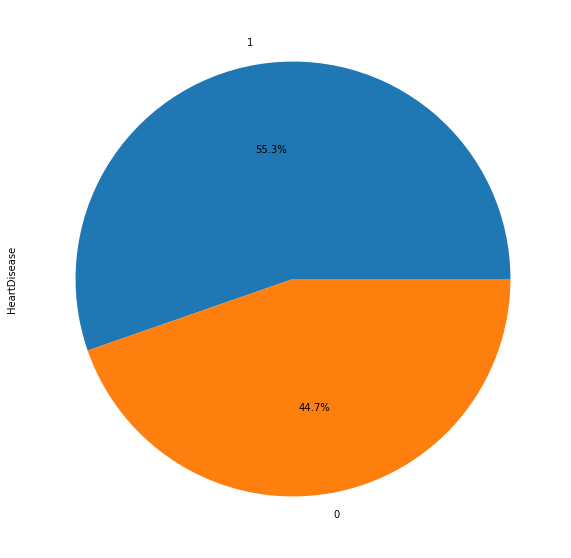

In [225]:
print(df["HeartDisease"].value_counts())
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%',figsize=(10,10));

In [226]:
y = df['HeartDisease']
print(f'Percentage of Heart Disease: % {round(y.value_counts(normalize=True)[1]*100,2)} --> \
({y.value_counts()[1]} cases for Heart Disease)\nPercentage of NOT Heart Disease: % {round(y.value_counts(normalize=True)[0]*100,2)} --> ({y.value_counts()[0]} cases for NOT Heart Disease)')

Percentage of Heart Disease: % 55.34 --> (508 cases for Heart Disease)
Percentage of NOT Heart Disease: % 44.66 --> (410 cases for NOT Heart Disease)


In [227]:
df['HeartDisease'].describe()

count   918.000
mean      0.553
std       0.497
min       0.000
25%       0.000
50%       1.000
75%       1.000
max       1.000
Name: HeartDisease, dtype: float64

In [228]:
df[df['HeartDisease']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
RestingBP,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
Cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
FastingBS,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
Oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
HeartDisease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [229]:
df[df['HeartDisease']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
RestingBP,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
Cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
FastingBS,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
MaxHR,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
Oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
HeartDisease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [230]:
print( f"Skewness: {df['HeartDisease'].skew()}")

Skewness: -0.21508633825088655


In [231]:
print( f"Kurtosis: {df['HeartDisease'].kurtosis()}")

Kurtosis: -1.9580084425329685


In [232]:
df['HeartDisease'].iplot(kind='hist')

**Spliting Dataset into numeric & categoric features**

In [233]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


### Numerical Columns

In [234]:
df[numerical].head().T

,0,1,2,3,4
Age,40.000,49.000,37.000,48.000,54.000
RestingBP,140.000,160.000,130.000,138.000,150.000
Cholesterol,289.000,180.000,283.000,214.000,195.000
FastingBS,0.000,0.000,0.000,0.000,0.000
MaxHR,172.000,156.000,98.000,108.000,122.000
Oldpeak,0.000,1.000,0.000,1.500,0.000


In [235]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.000,53.511,9.433,28.000,47.000,54.000,60.000,77.000
RestingBP,918.000,132.397,18.514,0.000,120.000,130.000,140.000,200.000
Cholesterol,918.000,198.800,109.384,0.000,173.250,223.000,267.000,603.000
FastingBS,918.000,0.233,0.423,0.000,0.000,0.000,0.000,1.000
MaxHR,918.000,136.809,25.460,60.000,120.000,138.000,156.000,202.000
Oldpeak,918.000,0.887,1.067,-2.600,0.000,0.600,1.500,6.200


In [236]:
df[numerical].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
FastingBS,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000


In [237]:
df[numerical].iplot(kind='hist');

In [238]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

In [239]:
for i in numerical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

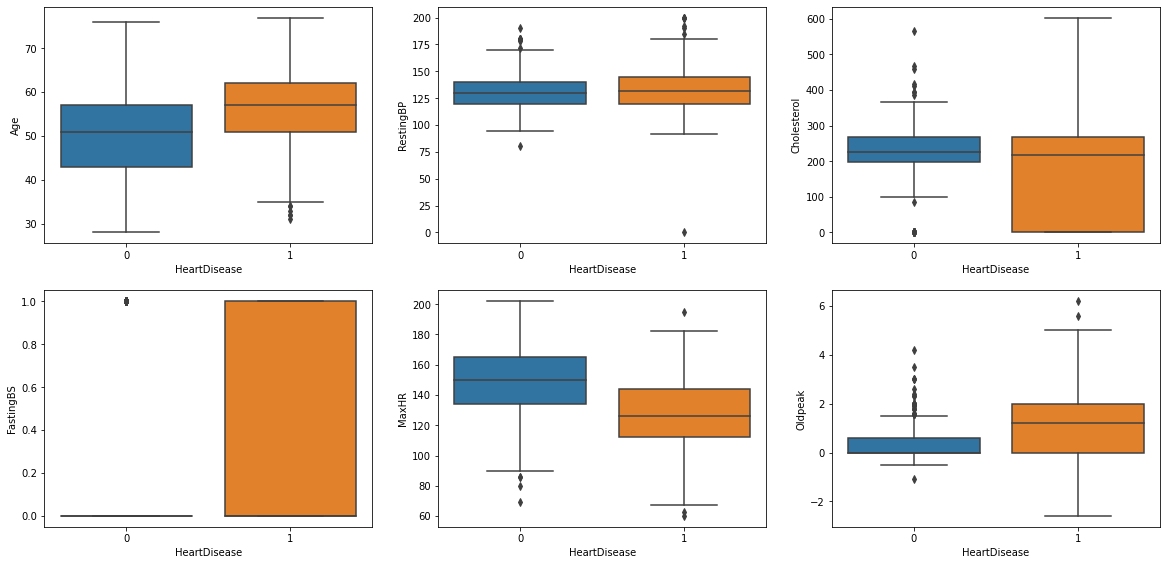

In [240]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "HeartDisease":
        index += 1
        plt.subplot(4,3,index)
        sns.boxplot(x='HeartDisease',y=feature,data=df)

In [241]:
fig = px.scatter_3d(df, 
                    x='RestingBP',
                    y='Age',
                    z='Sex',
                    color='HeartDisease')
fig.show();

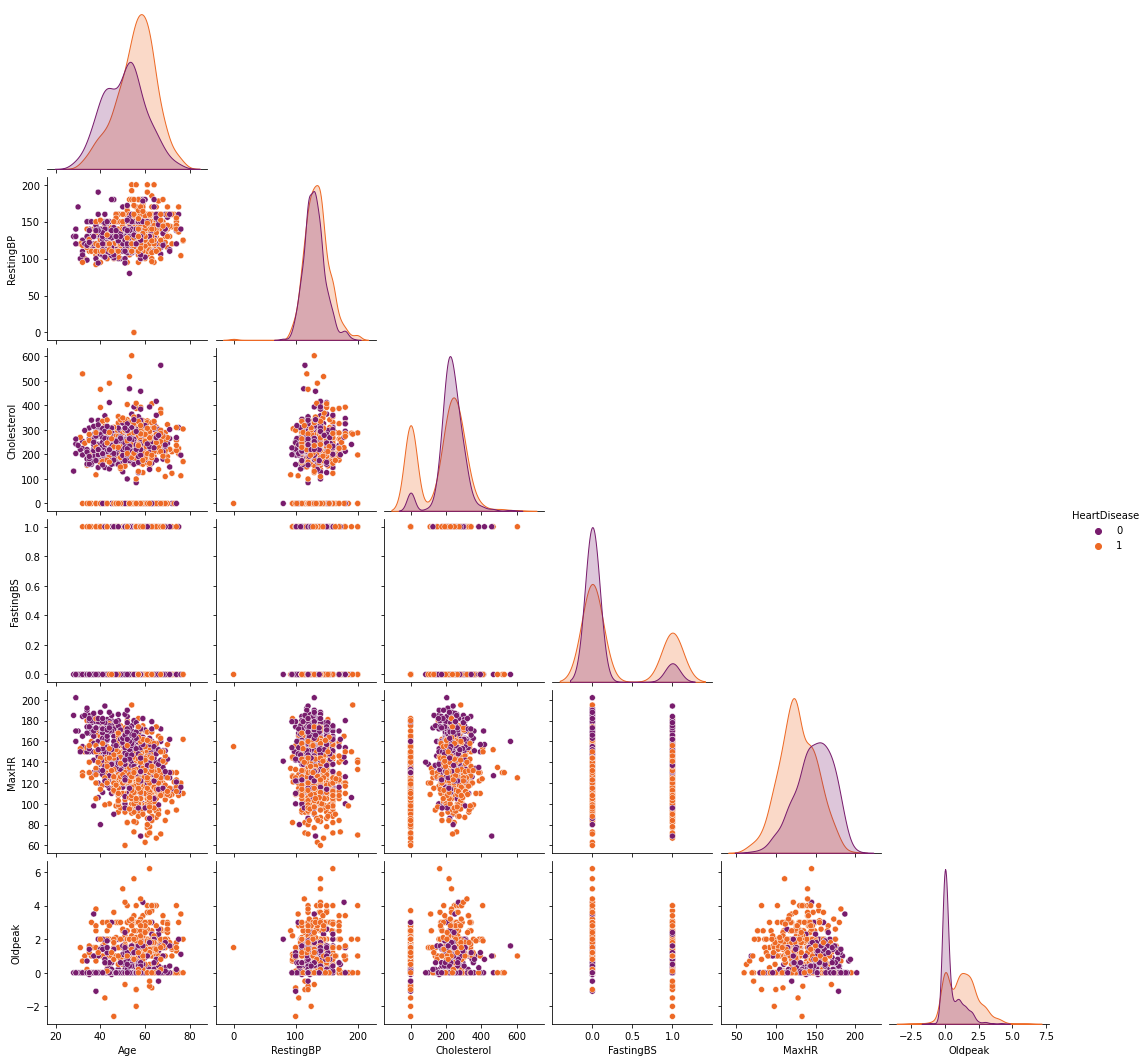

In [242]:
sns.pairplot(df, hue="HeartDisease", palette="inferno", corner=True);

**The Examination of Skewness & Kurtosis**

In [243]:
skew_vals = df.skew().sort_values(ascending=False)
skew_vals

FastingBS       1.264
Oldpeak         1.023
RestingBP       0.180
MaxHR          -0.144
Age            -0.196
HeartDisease   -0.215
Cholesterol    -0.610
dtype: float64

In [244]:
skew_limit = 0.5 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

FastingBS      1.264
Oldpeak        1.023
Cholesterol   -0.610
dtype: float64

In [245]:
#Interpreting Skewness 

for skew in skew_vals:
    if -0.5 < skew < 0.5:
        print ("A skewness value of", '\033[1m', Fore.GREEN, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
    elif  -0.5 < skew < -1.0 or 0.5 < skew < 1.0:
        print ("A skewness value of", '\033[1m', Fore.YELLOW, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
    else:
        print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

A skewness value of   -0.19593302867569365  means that the distribution is approx.   symmetric 
A skewness value of   0.1798393100516288  means that the distribution is approx.   symmetric 
A skewness value of   -0.6100864307268192  means that the distribution is approx.   highly skewed 
A skewness value of   1.2644841750727027  means that the distribution is approx.   highly skewed 
A skewness value of   -0.14435941846180994  means that the distribution is approx.   symmetric 
A skewness value of   1.0228720218107528  means that the distribution is approx.   highly skewed 
A skewness value of   -0.21508633825088655  means that the distribution is approx.   symmetric 


Kurtosis are of three types:

Mesokurtic: When the tails of the distibution is similar to the normal distribution then it is mesokurtic. The kutosis for normal distibution is 3.

Leptokurtic: If the kurtosis is greater than 3 then it is leptokurtic. In this case, the tails will be heaviour than the normal distribution which means lots of outliers are present in the data. It can be recognized as thin bell shaped distribution with peak higher than normal distribution.

Platykurtic: Kurtosis will be less than 3 which implies thinner tail or lack of outliers than normal distribution.In case of platykurtic, bell shaped distribution will be broader and peak will be lower than the mesokurtic.
Hair et al. (2010) and Bryne (2010) argued that data is considered to be normal if Skewness is between ‐2 to +2 and Kurtosis is between ‐7 to +7.

Multi-normality data tests are performed using leveling asymmetry tests (skewness < 3), (Kurtosis between -2 and 2) and Mardia criterion (< 3). Source Chemingui, H., & Ben lallouna, H. (2013).

Skewness and kurtosis index were used to identify the normality of the data. The result suggested the deviation of data from normality was not severe as the value of skewness and kurtosis index were below 3 and 10 respectively (Kline, 2011). Source Yadav, R., & Pathak, G. S. (2016).

In [246]:
kurtosis_vals = df.kurtosis().sort_values(ascending=False)
kurtosis_vals

RestingBP       3.271
Oldpeak         1.203
Cholesterol     0.118
Age            -0.386
FastingBS      -0.402
MaxHR          -0.448
HeartDisease   -1.958
dtype: float64

In [247]:
#Calculating Kurtosis 

kurtosis_limit = 7 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
kurtosis_vals = df.kurtosis()
kurtosis_cols = kurtosis_vals[abs(kurtosis_vals) > kurtosis_limit].sort_values(ascending=False)
kurtosis_cols

Series([], dtype: float64)

For preventing data leakage, we need to handle with kurtosis and skewness issue after splitting our data into train and test sets.

Before deeping into the analysis it would be benefical to examine the correlation among variables using heatmap.

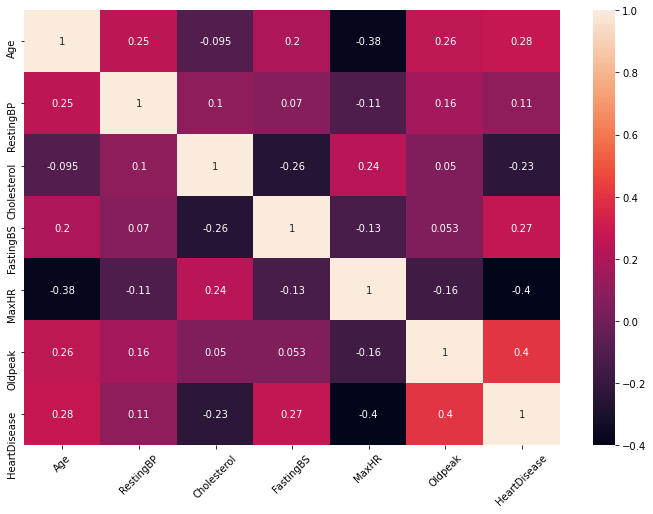

In [248]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=45);

In [249]:
df_temp = df.corr()

count = "Done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")
        else:
            print(f"For {col} and {i}, there is NO multicollinearity problem") 

print("\033[1mThe number of strong corelated features:\033[0m", count) 

For Age and Age, there is NO multicollinearity problem
For Age and RestingBP, there is NO multicollinearity problem
For Age and Cholesterol, there is NO multicollinearity problem
For Age and FastingBS, there is NO multicollinearity problem
For Age and MaxHR, there is NO multicollinearity problem
For Age and Oldpeak, there is NO multicollinearity problem
For Age and HeartDisease, there is NO multicollinearity problem
For RestingBP and Age, there is NO multicollinearity problem
For RestingBP and RestingBP, there is NO multicollinearity problem
For RestingBP and Cholesterol, there is NO multicollinearity problem
For RestingBP and FastingBS, there is NO multicollinearity problem
For RestingBP and MaxHR, there is NO multicollinearity problem
For RestingBP and Oldpeak, there is NO multicollinearity problem
For RestingBP and HeartDisease, there is NO multicollinearity problem
For Cholesterol and Age, there is NO multicollinearity problem
For Cholesterol and RestingBP, there is NO multicolline

### Categorical Columns

In [250]:
df[categorical].head().T

,0,1,2,3,4
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingECG,Normal,Normal,ST,Normal,Normal
ExerciseAngina,N,N,N,Y,N
ST_Slope,Up,Flat,Up,Flat,Up


In [251]:
df[categorical].describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [252]:
for i in categorical:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

In [253]:
df[categorical].iplot(kind='hist');

In [254]:
df[categorical].iplot(kind='histogram',subplots=True,bins=50)

**Sex and HeartDisease**

In [255]:
df["Sex"].value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [256]:
df['Sex'].iplot(kind='hist', )

<AxesSubplot:xlabel='Sex', ylabel='Age'>

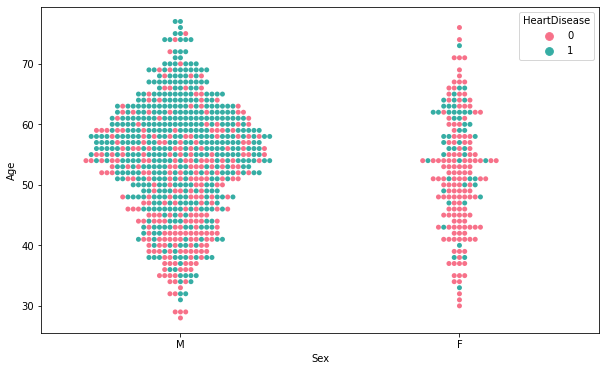

In [257]:
sns.swarmplot(y="Age", x="Sex", hue="HeartDisease", data=df, palette="husl")

**ChestPainType and HeartDisease**

In [258]:
df["ChestPainType"].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [259]:
df['ChestPainType'].iplot(kind='hist', )

<AxesSubplot:xlabel='ChestPainType', ylabel='Age'>

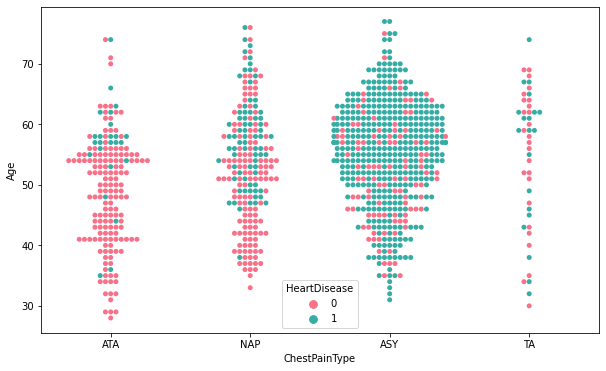

In [260]:
sns.swarmplot(y="Age", x="ChestPainType", hue="HeartDisease", data=df, palette="husl")

**RestingECG and HeartDisease**

In [261]:
df["RestingECG"].value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [262]:
df['RestingECG'].iplot(kind='hist', )

<AxesSubplot:xlabel='RestingECG', ylabel='Age'>

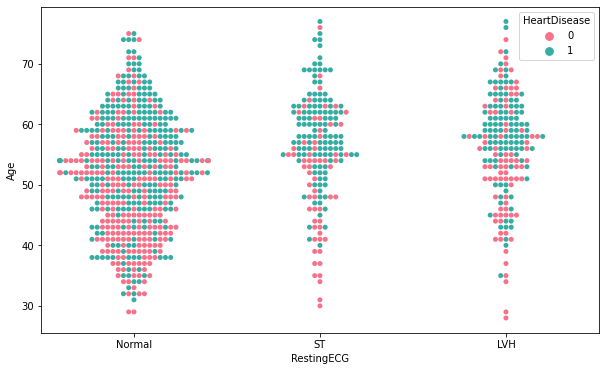

In [263]:
sns.swarmplot(y="Age", x="RestingECG", hue="HeartDisease", data=df, palette="husl")

**ExerciseAngina and HeartDisease**

In [264]:
df["ExerciseAngina"].value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [265]:
df['ExerciseAngina'].iplot(kind='hist', )

<AxesSubplot:xlabel='ExerciseAngina', ylabel='Age'>

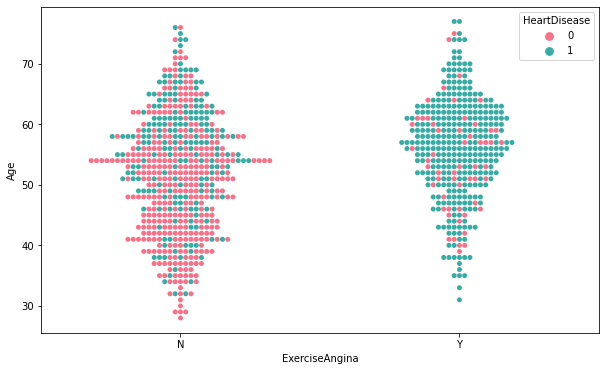

In [266]:
sns.swarmplot(y="Age", x="ExerciseAngina", hue="HeartDisease", data=df, palette="husl")

**ST_Slope and HeartDisease**

In [267]:
df["ST_Slope"].value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [268]:
df['ST_Slope'].iplot(kind='hist', )

<AxesSubplot:xlabel='ST_Slope', ylabel='Age'>

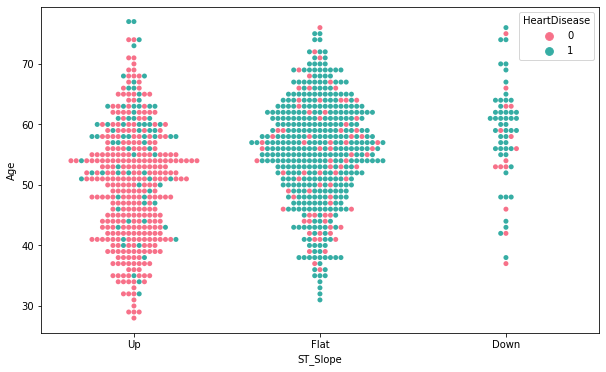

In [269]:
sns.swarmplot(y="Age", x="ST_Slope", hue="HeartDisease", data=df, palette="husl")

# Dummy Operations

In [271]:
# df.shape

(918, 12)

In [273]:
# df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000,Up,0


In [272]:
# df[categorical].value_counts()

Sex  ChestPainType  RestingECG  ExerciseAngina  ST_Slope
M    ASY            Normal      Y               Flat        109
     ATA            Normal      N               Up           64
     ASY            Normal      N               Flat         55
                    ST          Y               Flat         49
     NAP            Normal      N               Up           46
                                                           ... 
F    NAP            ST          Y               Flat          1
     TA             LVH         N               Up            1
                    Normal      N               Down          1
M    ATA            LVH         Y               Flat          1
     TA             ST          Y               Flat          1
Length: 95, dtype: int64

In [274]:
# df = pd.get_dummies(df, drop_first=True)

In [275]:
df.shape

(918, 16)

In [276]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.000,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.000,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.000,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.500,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.000,0,1,0,1,0,1,0,0,0,1


# Data Preprocessing

In [280]:
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]

### Train / Test and Split

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 101)

### Feature Scalling

In [283]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [284]:
X_train_scaled = scaler.fit_transform(X_train)

In [285]:
X_test_scaled = scaler.transform(X_test)

# General Insights Before Going Further

In [308]:
# General Insights Without Scaling
def models(X_train, y_train, class_weight):
    # Logistic Regression
    log = LogisticRegression(random_state=101, class_weight=class_weight)
    log.fit(X_train, y_train)
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=101, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train) 
   # SVC
    svc = SVC(random_state=101, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    # XGB
    xgb = XGBClassifier(random_state=101, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=50, random_state=101)
    ab.fit(X_train, y_train)
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=101)
    gb.fit(X_train, y_train)
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log.score(X_train, y_train)}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc.score(X_train, y_train)}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree.score(X_train, y_train)}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest.score(X_train, y_train)}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn.score(X_train, y_train)}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb.score(X_train, y_train)}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab.score(X_train, y_train)}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb.score(X_train, y_train)}")
    return log, svc, decision_tree, random_forest, knn, gb, ab, xgb

In [339]:
# deneme

def models(X_train, y_train, class_weight):
    # Logistic Regression
    log = LogisticRegression(random_state=101, class_weight=class_weight)
    log.fit(X_train, y_train)
    # Decision Tree
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', random_state=101, class_weight=class_weight)
    decision_tree.fit(X_train, y_train)
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=10, criterion = 'entropy', random_state=101, class_weight=class_weight)
    random_forest.fit(X_train, y_train)
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train) 
   # SVC
    svc = SVC(random_state=101, class_weight=class_weight)
    svc.fit(X_train, y_train) 
    # XGB
    xgb = XGBClassifier(random_state=101, class_weight=class_weight)
    xgb.fit(X_train, y_train)
    # AdaBoosting
    ab = AdaBoostClassifier(n_estimators=50, random_state=101)
    ab.fit(X_train, y_train)
    # GB GradientBoosting
    gb = GradientBoostingClassifier(random_state=101)
    gb.fit(X_train, y_train)
    # Model Accuracy on Training Data
    print(f"\033[1m1) Logistic Regression Training Accuracy:\033[0m {log}")
    print(f"\033[1m2) SVC Training Accuracy:\033[0m {svc}")    
    print(f"\033[1m3) Decision Tree Training Accuracy:\033[0m {decision_tree}")
    print(f"\033[1m4) Random Forest Training Accuracy:\033[0m {random_forest}")
    print(f"\033[1m5) KNN Training Accuracy:\033[0m {knn}")
    print(f"\033[1m6) GradiendBoosting Training Accuracy:\033[0m {gb}")
    print(f"\033[1m7) AdaBoosting Training Accuracy:\033[0m {ab}")
    print(f"\033[1m8) XGBoosting Training Accuracy:\033[0m {xgb}")
  
    return log.score(X_train, y_train), svc.score(X_train, y_train),decision_tree.score(X_train, y_train),random_forest.score(X_train, y_train),knn.score(X_train, y_train),gb.score(X_train, y_train),ab.score(X_train, y_train),xgb.score(X_train, y_train)

In [ ]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "SVM", "Random Forest", "XGBoost"],
                        "F1": [log_f1, svc_f1, rf_f1, xgb_f1],
                        "Recall": [log_recall, svc_recall, rf_recall, xgb_recall],
                        "Accuracy": [log_accuracy, svc_accuracy, rf_accuracy, xgb_accuracy]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(313)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

In [431]:
Scores = pd.DataFrame(columns = ["log_acc", "svc_acc", "decision_tree_acc", "random_forest_acc", "knn_acc", "gb_acc", "ab_acc", "xgb_acc"])

Basic = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, None)
Scores.loc[0] = Basic
Scaled = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, None)
Scores.loc[1] = Scaled
Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train, y_train, "balanced")
Scores.loc[2] = Balanced
Scaled_Balanced = [log_acc, svc_acc, decision_tree_acc, random_forest_acc, knn_acc, gb_acc, ab_acc, xgb_acc] = models(X_train_scaled, y_train, "balanced")
Scores.loc[3] = Scaled_Balanced

Scores.set_axis(['Basic', 'Scaled', 'Balanced', 'Scaled_Balanced'], axis='index', inplace=True)
Scores.style.background_gradient(cmap='RdPu')
#Scores.style.applymap(color="green", subset=['svc_acc'])

Scores

[17:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101)
2) SVC Training Accuracy: SVC(random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jo

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(random_state=101)
2) SVC Training Accuracy: SVC(random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(criterion='entropy', random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jo

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=101)
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.

<IPython.core.display.Javascript object>

1) Logistic Regression Training Accuracy: LogisticRegression(class_weight='balanced', random_state=101)
2) SVC Training Accuracy: SVC(class_weight='balanced', random_state=101)
3) Decision Tree Training Accuracy: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=101)
4) Random Forest Training Accuracy: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=101)
5) KNN Training Accuracy: KNeighborsClassifier(n_neighbors=3)
6) GradiendBoosting Training Accuracy: GradientBoostingClassifier(random_state=101)
7) AdaBoosting Training Accuracy: AdaBoostClassifier(random_state=101)
8) XGBoosting Training Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.

,log_acc,svc_acc,decision_tree_acc,random_forest_acc,knn_acc,gb_acc,ab_acc,xgb_acc
Basic,0.874,0.728,1.000,0.990,0.832,0.940,0.879,1.000
Scaled,0.862,0.883,1.000,0.990,0.910,0.940,0.879,1.000
Balanced,0.872,0.714,1.000,0.991,0.832,0.940,0.879,1.000
Scaled_Balanced,0.868,0.883,1.000,0.991,0.910,0.940,0.879,1.000


In [438]:
Scores

,log_acc,svc_acc,decision_tree_acc,random_forest_acc,knn_acc,gb_acc,ab_acc,xgb_acc
Basic,0.874,0.728,1.000,0.990,0.832,0.940,0.879,1.000
Scaled,0.862,0.883,1.000,0.990,0.910,0.940,0.879,1.000
Balanced,0.872,0.714,1.000,0.991,0.832,0.940,0.879,1.000
Scaled_Balanced,0.868,0.883,1.000,0.991,0.910,0.940,0.879,1.000


In [440]:
def _color_red_or_green(val):
    color = 'red' if val < 0.99 else 'green'
    return 'color: %s' % color

In [441]:
Scores.style.applymap(_color_red_or_green)

,log_acc,svc_acc,decision_tree_acc,random_forest_acc,knn_acc,gb_acc,ab_acc,xgb_acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


In [442]:
Scores.style.applymap(lambda x: "background-color: red" if x>0 else "background-color: white")

,log_acc,svc_acc,decision_tree_acc,random_forest_acc,knn_acc,gb_acc,ab_acc,xgb_acc
Basic,0.874359,0.728205,1.000000,0.989744,0.832051,0.939744,0.879487,1.000000
Scaled,0.861538,0.883333,1.000000,0.989744,0.910256,0.939744,0.879487,1.000000
Balanced,0.871795,0.714103,1.000000,0.991026,0.832051,0.939744,0.879487,1.000000
Scaled_Balanced,0.867949,0.883333,1.000000,0.991026,0.910256,0.939744,0.879487,1.000000


In [444]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

Scores.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)

,log_acc,svc_acc,decision_tree_acc,random_forest_acc,knn_acc,gb_acc,ab_acc,xgb_acc
Basic,color:white;background-color:darkblue,,color:white;background-color:darkblue,,,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue
Scaled,,color:white;background-color:darkblue,color:white;background-color:darkblue,,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue
Balanced,,,color:white;background-color:darkblue,color:white;background-color:darkblue,,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue
Scaled_Balanced,,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue,color:white;background-color:darkblue


In [445]:
Scores.style.apply(highlight_max, props='color:white;background-color:darkblue;', axis=0)\
         .apply(highlight_max, props='color:white;background-color:pink;', axis=1)\
         .apply(highlight_max, props='color:white;background-color:purple', axis=None)

TypeError: Function <function highlight_max at 0x0000014883E281F0> must return a DataFrame when passed to `Styler.apply` with axis=None

In [ ]:
df2.style.apply(highlight_max, props='color:white;background-color:darkblue;', axis=0)\
         .apply(highlight_max, props='color:white;background-color:pink;', axis=1)\
         .apply(highlight_max, props='color:white;background-color:purple', axis=None)



In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

# Modelling Implementing

# Implement Logistic Regression and Evaluate

In [42]:
log_model=LogisticRegression(class_weight = "balanced")

In [43]:
log_model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [44]:
log_pred = log_model.predict(X_test_scaled)

In [45]:
log_pred_proba = log_model.predict_proba(X_test_scaled)

In [46]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["pred"] = log_pred
test_data["pred_proba"] = log_pred_proba[:,1]
test_data.sample(10)

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,pred,pred_proba
1877,7.0911316,205.3041489,12190.1716015,7.0448330,313.4117075,374.5231970,11.8383129,47.6536419,5.0262707,0,0,0.4945735
471,4.1975836,189.4736767,31292.1277037,7.1052043,333.9004977,370.7714128,11.9864018,50.3228304,5.2064802,0,1,0.5161309
247,8.8964190,222.2562929,8870.9029659,6.0113424,332.0026304,425.2268617,10.8477368,66.4621920,3.7009457,0,0,0.4863308
2087,6.5274406,181.0729954,22444.0817774,10.4749769,271.8627923,351.0637876,11.9963651,66.4621920,3.5671805,0,1,0.5408977
299,8.0754945,195.8049958,29483.6018539,10.4938409,298.7372193,321.7483389,9.7510863,72.7344231,3.6829196,1,1,0.5483599
1949,6.8096445,179.7195206,35001.1447916,8.6819835,333.9004977,360.9328038,13.6333497,72.7179198,3.1838036,1,1,0.5295484
270,7.2918883,127.5442971,27784.0484840,9.7544759,247.3354119,439.6493286,17.2850417,59.5563295,5.3287128,1,1,0.5347479
1407,8.4705460,199.4897165,26559.3804056,7.9043813,351.7389246,491.5197053,9.5048797,66.1463551,2.9358020,0,1,0.5139166
631,7.0911316,191.7642561,10830.8012454,6.3628894,333.9004977,492.2003090,17.2916452,43.2725452,4.2667754,0,0,0.4655676
408,6.4437537,196.6159916,25740.4125907,2.4843800,435.6727646,352.3536228,16.9244186,33.0518877,4.4986849,1,0,0.4446049


### Model Performance on Classification Tasks

In [47]:
print(confusion_matrix(y_test, log_pred))
print(classification_report(y_test, log_pred))

[[279 231]
 [150 159]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



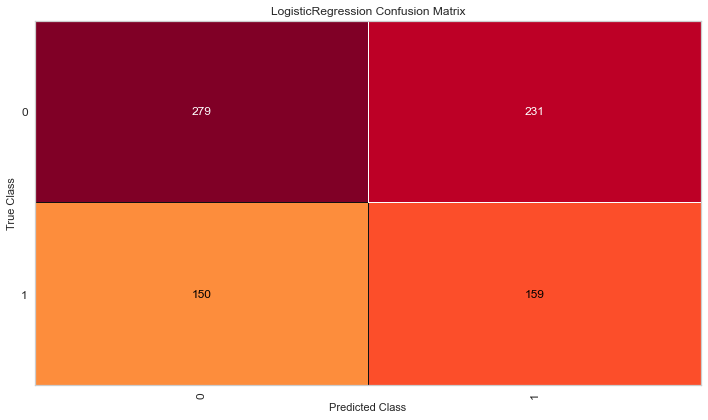

In [48]:
cm = ConfusionMatrix(log_model)
cm.fit(X_train_scaled, y_train)
cm.score(X_test_scaled, y_test)
cm.show();

### Cross Validate

In [49]:
model = LogisticRegression(class_weight = "balanced")
model

LogisticRegression(class_weight='balanced')

In [50]:
scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision','recall','f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
#df_scores
df_scores.mean()[2:]

test_accuracy    0.4818849
test_precision   0.3748772
test_recall      0.4705649
test_f1          0.4168566
dtype: float64

### ROC (Receiver Operating Curve) and AUC (Area Under Curve)

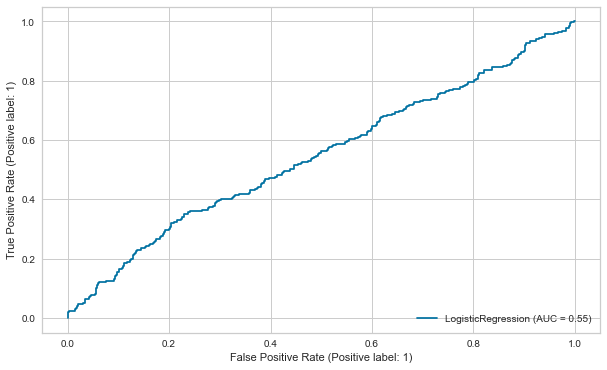

In [51]:
plot_roc_curve(log_model, X_test_scaled, y_test);

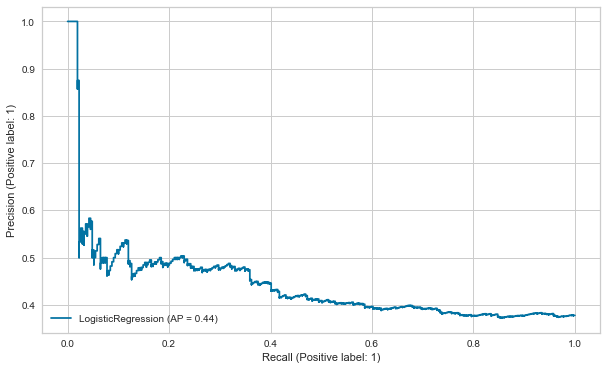

In [52]:
plot_precision_recall_curve(log_model, X_test_scaled, y_test);

### Finding Best Threshold

In [53]:
log_pred_proba = log_model.predict_proba(X_train_scaled)
roc_auc_score(y_train, log_pred_proba[:,1])

0.5215726499994452

In [54]:
fp_rate, tp_rate, thresholds = roc_curve(y_train, log_pred_proba[:,1])

In [55]:
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.5120265492885842

In [56]:
test_data.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,pred,pred_proba
2947,7.0911316,183.5211070,20461.2527102,7.3332122,333.1194759,356.3690224,20.1790289,67.0199032,4.8866338,0,0,0.4863334
2782,6.6431587,188.9135411,32873.8200217,6.7915094,333.8488419,336.5615010,14.7068103,67.8448489,4.5621977,1,1,0.5135902
1644,7.8460579,224.0588768,23264.1099677,5.9223670,300.4026201,387.9713358,13.4067375,43.0751865,2.4879686,0,0,0.4924927
70,7.1604672,183.0893100,6743.3460655,3.8030364,277.5990986,428.0363444,9.7996247,90.0353737,3.8848910,0,1,0.5071992
2045,6.6153501,179.2406613,26392.8636119,9.3091600,333.9004977,496.3635615,12.7865954,78.2623686,4.4534433,1,1,0.5234929


In [57]:
test_data["pred2"] = test_data["pred_proba"].apply(lambda x : 1 if x >= optimal_threshold else 0)

In [58]:
test_data.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,pred,pred_proba,pred2
2947,7.0911316,183.5211070,20461.2527102,7.3332122,333.1194759,356.3690224,20.1790289,67.0199032,4.8866338,0,0,0.4863334,0
2782,6.6431587,188.9135411,32873.8200217,6.7915094,333.8488419,336.5615010,14.7068103,67.8448489,4.5621977,1,1,0.5135902,1
1644,7.8460579,224.0588768,23264.1099677,5.9223670,300.4026201,387.9713358,13.4067375,43.0751865,2.4879686,0,0,0.4924927,0
70,7.1604672,183.0893100,6743.3460655,3.8030364,277.5990986,428.0363444,9.7996247,90.0353737,3.8848910,0,1,0.5071992,0
2045,6.6153501,179.2406613,26392.8636119,9.3091600,333.9004977,496.3635615,12.7865954,78.2623686,4.4534433,1,1,0.5234929,1


In [59]:
log_pred2 = test_data["pred2"]

In [60]:
print(confusion_matrix(y_test,log_pred2))
print(classification_report(y_test,log_pred2))

[[398 112]
 [207 102]]
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       510
           1       0.48      0.33      0.39       309

    accuracy                           0.61       819
   macro avg       0.57      0.56      0.55       819
weighted avg       0.59      0.61      0.59       819



In [61]:
print(confusion_matrix(y_test,log_pred))
print(classification_report(y_test,log_pred))

[[279 231]
 [150 159]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



In [65]:
log_model=LogisticRegression(class_weight = "balanced")
log_model.fit(X_train_scaled, y_train)
y_pred=log_model.predict(X_test_scaled)
y_pred_train = log_model.predict(X_train_scaled)
log_acc = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_pred_train, y_test, y_pred)

[[279 231]
 [150 159]]
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       510
           1       0.41      0.51      0.45       309

    accuracy                           0.53       819
   macro avg       0.53      0.53      0.52       819
weighted avg       0.56      0.53      0.54       819



,train_set,test_set
Accuracy,0.5144485,0.5347985
Precision,0.4057239,0.4076923
Recall,0.4974200,0.5145631
f1,0.4469170,0.4549356


In [66]:
model = LogisticRegression(class_weight = "balanced")

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

    fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1
1  0.1908824   0.0156231      0.4959350       0.3738318    0.4123711 0.3921569
2  0.0781155   0.0000000      0.5000000       0.3796296    0.4226804 0.4000000
3  0.0312562   0.0000000      0.4959350       0.3636364    0.3711340 0.3673469
4  0.0312548   0.0156100      0.4918699       0.3906250    0.5154639 0.4444444
5  0.0468655   0.0000000      0.4959350       0.3865546    0.4742268 0.4259259
6  0.0312448   0.0156369      0.5243902       0.4090909    0.4639175 0.4347826
7  0.0312421   0.0156233      0.4796748       0.3675214    0.4432990 0.4018692
8  0.0156140   0.0156410      0.4938776       0.3793103    0.4583333 0.4150943
9  0.0312307   0.0156381      0.4897959       0.3813559    0.4639175 0.4186047
10 0.0156085   0.0156248      0.4979592       0.3968254    0.5154639 0.4484305
--------------------
test_accuracy    0.4965372
test_precision   0.3828381
test_recall      0.4540808
test_f1          0.4148655
dt

# Implement XGBoost and Evaluate

In [227]:
from xgboost import XGBClassifier

In [228]:
xgb = XGBClassifier(random_state=42).fit(X_train, y_train)

In [229]:
y_pred = xgb.predict(X_test)

In [230]:
xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [231]:
y_train_pred = xgb.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

### Gridsearch

In [232]:
param_grid = {"n_estimators":[100, 300],'max_depth':[3,5,6], "learning_rate": [0.1, 0.3],
             "subsample":[0.5, 1], "colsample_bytree":[0.5, 1]}

In [233]:
xgb_model = XGBClassifier(random_state=42)

In [ ]:
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

In [ ]:
xgb_grid.best_estimator_

<!-- from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns -->



In [ ]:
xgb_grid.best_params_

In [ ]:
y_pred = xgb_grid.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
y_train_pred = xgb_grid.predict(X_train)
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

# Implement Random Forest and Evaluate

In [97]:
def train_val(y_train, y_train_pred, y_test, y_pred):
    
    scores = {"train_set": {"Accuracy" : accuracy_score(y_train, y_train_pred),
                            "Precision" : precision_score(y_train, y_train_pred),
                            "Recall" : recall_score(y_train, y_train_pred),                          
                            "f1" : f1_score(y_train, y_train_pred)},
    
              "test_set": {"Accuracy" : accuracy_score(y_test, y_pred),
                           "Precision" : precision_score(y_test, y_pred),
                           "Recall" : recall_score(y_test, y_pred),                          
                           "f1" : f1_score(y_test, y_pred)}}
    
    return pd.DataFrame(scores)

In [103]:
rf_model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)
rf_acc = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [104]:
model = RandomForestClassifier(class_weight = "balanced", random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])

In [105]:
param_grid = {'n_estimators':[50, 100, 300],
             'max_features':[2, 3, 4],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [106]:
model = RandomForestClassifier(class_weight = "balanced", random_state=101)
rf_grid_model = GridSearchCV(model, param_grid, scoring = "recall", n_jobs = -1, verbose = 2).fit(X_train, y_train)

In [107]:
rf_grid_model.best_params_

In [108]:
y_pred = rf_grid_model.predict(X_test)
y_train_pred = rf_grid_model.predict(X_train)
rf_tuned_acc = accuracy_score(y_test, y_pred)
rf_tuned_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

# Implement KNN and Evaluate

In [115]:
test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled,y_train) 
   
    y_pred_test = knn_model.predict(X_test_scaled)
    
    test_error = 1 - recall_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

In [116]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.56, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.69, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

In [125]:
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [126]:
knn_model = KNeighborsClassifier(n_neighbors = 2)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [127]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [128]:
knn_model = KNeighborsClassifier(n_neighbors = 4)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [129]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)
knn_acc = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
train_val(y_train, y_train_pred, y_test, y_pred)

In [130]:
model = KNeighborsClassifier(n_neighbors = 2)

scores = cross_validate(model, X_train_scaled, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
print(df_scores)
print("--------------------")
print(df_scores.mean()[2:])